In [1]:
import argparse
import os
import time
from pathlib import Path

import numpy as np
import pytorch_lightning as pl
import torch
import wandb
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
import timm
from torchvision.datasets import CIFAR10, CIFAR100
from tqdm import tqdm

## 
# plot.py
import functools

import matplotlib
import matplotlib.pyplot as plt
import datetime 

import scipy.stats
from sklearn.metrics import auc, roc_curve

##
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")

In [2]:
# for vit_large_patch16_224_cifar10, CIFAR-10
lr=0.02
epochs=25
n_shadows = 64
shadow_id = -1 
model = "efficientnet_b7"
dataset = "cifar10"
pkeep = 0.5
savedir = f"exp/{model}_{dataset}"
debug = True

# for vgg19, CIFAR-10
''' 
lr = 0.02
epochs = 25
n_shadows = 64
shadow_id = -1 
model = "vgg19"
dataset = "cifar10"
pkeep = 0.5
savedir = f"exp/{model}_{dataset}"
debug = True
'''

' \nlr = 0.02\nepochs = 25\nn_shadows = 64\nshadow_id = -1 \nmodel = "vgg19"\ndataset = "cifar10"\npkeep = 0.5\nsavedir = f"exp/{model}_{dataset}"\ndebug = True\n'

In [3]:
# inference
n_queries = 2

In [4]:
seed = 1583745484

# Train victim model

In [5]:
# Dataset
if model == "vit_large_patch16_224":
    train_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
else: 
    train_transform = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
        ]
    )
    test_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
        ]
    )


torch.manual_seed(seed)
datadir = Path().home() / "dataset"

if dataset == "cifar10":
    print("import cifar10...")
    train_ds = CIFAR10(root=datadir, train=True, download=True, transform=train_transform)
    test_ds = CIFAR10(root=datadir, train=False, download=True, transform=test_transform)
elif dataset == "cifar100":
    print("import cifar100...")
    train_ds = CIFAR100(root=datadir, train=True, download=True, transform=train_transform)
    test_ds = CIFAR100(root=datadir, train=False, download=True, transform=test_transform)
else:
    raise ValueError("undefined dataset")

# train_ds, eval_ds = random_split(train_ds, [0.8, 0.2])

import cifar10...
Files already downloaded and verified
Files already downloaded and verified


In [6]:
size = len(train_ds)
np.random.seed(seed)

In [7]:
size

50000

In [8]:
keep = np.random.choice(size, size=int(pkeep * size), replace=False)
keep.sort()

keep_bool = np.full((size), False)
keep_bool[keep] = True

In [9]:
train_ds = torch.utils.data.Subset(train_ds, keep)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=4)

In [10]:
len(train_ds) # 50%(pkeep) of training dataset

25000

In [11]:
def network(arch: str, pretrained_: bool):
    print(f'arch: {arch}, pretrained: {pretrained_}') 
    
    # https://pytorch.org/vision/stable/models.html
    TORCHVISION_MODELS = ['resnet18', 'resnet50', 'resnet101', 'vgg16', 'vgg19', 'densenet121', 
                          'wide_resnet50_2', 'wide_resnet101_2',
                          'densenet201', 'mobilenet_v2', 'inception_v3', 
                          'efficientnet_b0', 'efficientnet_b7', 
                          'squeezenet1_0', 'alexnet', 'googlenet', 'shufflenet_v2_x1_0']
    
    # https://github.com/huggingface/pytorch-image-models
    PYTORCH_IMAGE_MODELS = ['vit_base_patch16_224', 'vit_large_patch16_224', 'deit_base_patch16_224',
                        'convnext_base', 'convnext_large']
    
    if arch in TORCHVISION_MODELS:
        model = models.__dict__[arch](pretrained=pretrained_)
    elif arch in PYTORCH_IMAGE_MODELS:
        model = timm.create_model(arch, pretrained=pretrained_)
    else:
        raise ValueError(f"Model {arch} not available.")

    dataset_classes = {"cifar10": 10, "cifar100": 100}
    n_classes = dataset_classes.get(dataset)

    print("n_classes: ", n_classes)
    
    if not n_classes:
        raise ValueError(f"Unsupported dataset '{args.dataset}'")

    # print("model: ", model)

    if arch == "vgg19": # for VGG-19
        num_features = model.classifier[6].in_features
        m.classifier[6] = nn.Linear(num_features, n_classes)      
    elif arch == "vit_large_patch16_224": # for ViT (vision transformer) 
        num_features = model.head.in_features
        model.head = nn.Linear(num_features, n_classes)        
    elif arch == "efficientnet_b7": # for efficientnet
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, n_classes)
    else:
        raise ValueError("undefined dataset")    
        
    return model


@torch.no_grad()
def get_acc(model, dl):
    acc = []
    for x, y in dl:
        x, y = x.to(DEVICE), y.to(DEVICE)
        acc.append(torch.argmax(model(x), dim=1) == y)
    acc = torch.cat(acc)
    acc = torch.sum(acc) / len(acc)

    return acc.item()


def freeze_interdemidate_layers(model, model_name):
    """
    Freeze specific layers of a model for efficient fine-tuning.
    
    Parameters:
    - model (torch.nn.Module): The model to apply freezing to.
    - model_name (str): The name of the model.
    """
    #if model_name == "vgg19":
    #    print("Freezing VGG-19 intermediate layers...")
    #    for param in model.features.parameters():
    #        param.requires_grad = False
    
    if model_name == "vit_large_patch16_224":
        print("Freezing ViT-Large intermediate layers...")
        for name, param in model.named_parameters():
            if "head" not in name:
                param.requires_grad = False
    
    #elif model_name == "efficientnet_b7":
    #    print("Freezing EfficientNet-B7 intermediate layers...")
    #    for param in model.parameters():
    #        param.requires_grad = False
    #    for param in model.classifier[1].parameters():
    #        param.requires_grad = True
    
    else:
        print(f"Do not freeze layers for model: {model_name}")
    
    return model

In [16]:
m = network(model, pretrained_=False)
m = m.to(DEVICE)
# print(m)

# For efficient fine-tune, freeze some intermediate layers within model
m = freeze_interdemidate_layers(m, model)

arch: efficientnet_b7, pretrained: False
n_classes:  10
Do not freeze layers for model: efficientnet_b7


In [17]:
optim = torch.optim.SGD(m.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)

In [18]:
# wandb.init(project="lira", mode="disabled" if debug else "online")
# wandb.config.update(args)

for epoch in range(epochs):
    m.train()
    loss_total = 0
    pbar = tqdm(train_dl)
    for itr, (x, y) in enumerate(pbar):
        x, y = x.to(DEVICE), y.to(DEVICE)

        outputs = m(x)
        loss = F.cross_entropy(outputs, y)
        loss_total += loss
        
        pbar.set_postfix_str(f"loss: {loss:.2f}")
        optim.zero_grad()
        loss.backward()
        optim.step()
    sched.step()

    test_acc = get_acc(m, test_dl)
    print(f"[Epoch {epoch}] Test Accuracy: {test_acc:.4f}")
    # wandb.log({"loss": loss_total / len(train_dl)})

print(f"[test] acc_test: {get_acc(m, test_dl):.4f}")
# wandb.log({"acc_test": get_acc(m, test_dl)})

savedir_victim = os.path.join(savedir, "victim")
os.makedirs(savedir_victim, exist_ok=True)
np.save(savedir_victim + "/keep.npy", keep_bool)
torch.save(m.state_dict(), savedir_victim + "/model.pt")
print('save done')

100%|██████████| 196/196 [00:19<00:00, 10.01it/s, loss: 3.07]


[Epoch 0] Test Accuracy: 0.0975


100%|██████████| 196/196 [00:19<00:00, 10.16it/s, loss: 3.01]


[Epoch 1] Test Accuracy: 0.1080


100%|██████████| 196/196 [00:19<00:00, 10.10it/s, loss: 3.42]


[Epoch 2] Test Accuracy: 0.1013


100%|██████████| 196/196 [00:19<00:00, 10.02it/s, loss: 2.41]


[Epoch 3] Test Accuracy: 0.1029


100%|██████████| 196/196 [00:19<00:00, 10.13it/s, loss: 2.62]


[Epoch 4] Test Accuracy: 0.1009


100%|██████████| 196/196 [00:19<00:00, 10.09it/s, loss: 4.81]


[Epoch 5] Test Accuracy: 0.1024


100%|██████████| 196/196 [00:19<00:00,  9.91it/s, loss: 4.03]


KeyboardInterrupt: 

# Inference

In [28]:
# inference from victim model
# run below script at ~/lira-pytorch_

# CUDA_VISIBLE_DEVICES=0 python3 -u inference.py     --model vit_large_patch16_224 --dataset cifar10     --mode eval --savedir=exp/vit_large_patch16_224_cifar10/victim

In [27]:
# inference from shadow models
# run below script at ~/lira-pytorch_

# bash scripts/run_infer-vgg19_n_shadows_64.sh > run_infer-vgg19_n_shadows_64.log 2>&1 &

# Computer score (logit scaling; Ø(p) = log(p/(1-p)) )

In [47]:
# run below script at ~/lira-pytorch_
# compute scores for both victim model and shadow models

# python score.py --dataset cifar10 --savedir exp/vit_large_patch16_224_cifar10 --mode eval

# Evaluate: 
## 1. generate distributions (Q_in, Q_out), 
## 2. then perform online/offline attack by estimating likeliehood ratio (Λ)

In [16]:
if dataset == "cifar10":
    print("import cifar10...")
    _train_ds = CIFAR10(root=datadir, train=True, download=True, transform=train_transform)
    test_ds = CIFAR10(root=datadir, train=False, download=True, transform=test_transform)
elif dataset == "cifar100":
    print("import cifar100...")
    _train_ds = CIFAR100(root=datadir, train=True, download=True, transform=train_transform)
    test_ds = CIFAR100(root=datadir, train=False, download=True, transform=test_transform)
else:
    raise ValueError("undefined dataset")

torch.manual_seed(seed)
_, eval_ds = random_split(_train_ds, [0.8, 0.2])

import cifar100...
Files already downloaded and verified
Files already downloaded and verified


In [17]:
print("train_ds: ", len(train_ds)) # for training victim model T among T + S 
print("eval_ds: ", len(eval_ds))

### desirable output: 

# train_ds:  25000 (50%(or pkeep) of training dataset for victim model)
# eval_ds:  10000

train_ds:  25000
eval_ds:  10000


In [18]:
# load scores from victim model
train_indices = set(train_ds.indices) # = T 
eval_in_train = [True if idx in train_indices else False for idx in eval_ds.indices] # T2
print("eval_in_train: ", sum(eval_in_train))

v_scores = np.load(os.path.join(savedir, "victim", "scores.npy"))
v_keep = np.array(eval_in_train) # eval_ds ^ train_ds; 

v_scores_r = v_scores.reshape(1, *v_scores.shape)
v_keep_r = v_keep.reshape(1, v_scores.shape[0])
v_scores = v_scores_r
v_keep = v_keep_r

print("v_scores: ", v_scores.shape)
print("v_keep: ", v_keep.shape)

eval_in_train:  5118
v_scores:  (1, 10000, 2)
v_keep:  (1, 10000)


In [19]:
v_scores

array([[[-1.05158626, -0.2246939 ],
        [ 0.44410044,  3.95609476],
        [ 6.45925391,  6.09259564],
        ...,
        [ 3.0075446 ,  1.96507176],
        [ 6.59489829,  6.6454022 ],
        [-1.04228096, -0.95778206]]])

In [20]:
v_keep

array([[False,  True,  True, ...,  True,  True, False]])

In [21]:
# load scores from shadow models
def load_data():
    """
    Load our saved scores and then put them into a big matrix.
    """
    global scores, keep
    scores = []
    keep = []

    paths = []

    for path in os.listdir(savedir):
        if path == "victim":
            continue
        paths.append(path)
        
        s_ = np.load(os.path.join(savedir, path, "scores.npy"))
        # k_ = np.load(os.path.join(savedir, path, "keep.npy"))
        k_ = np.zeros((10000,), dtype=bool)

        scores.append(s_)
        keep.append(k_)
        # print("s_: ", s_.shape)
        # print("k_: ", k_.shape)

    print("paths: ", paths)
    
    scores = np.array(scores)
    keep = np.array(keep)

    return scores, keep

In [22]:
scores, keep = load_data()

print("scores: ", scores.shape)
# print(scores)
print("keep: ", keep.shape) # False for all;
# print(keep)

paths:  ['42', '35', '48', '1', '14', '63', '51', '26', '21', '56', '19', '6', '13', '32', '45', '38', '36', '41', '60', '17', '8', '2', '25', '52', '58', '55', '22', '28', '10', '5', '46', '31', '39', '44', '33', '57', '20', '12', '7', '18', '62', '15', '0', '27', '50', '49', '34', '43', '30', '47', '29', '23', '54', '4', '11', '3', '9', '16', '61', '59', '53', '24', '40', '37']
scores:  (64, 10000, 2)
keep:  (64, 10000)


In [23]:
np.isnan(scores).any()

False

In [24]:
def sweep(score, x):
    """
    Compute a ROC curve and then return the FPR, TPR, AUC, and ACC.
    """
    fpr, tpr, _ = roc_curve(x, -score)
    acc = np.max(1 - (fpr + (1 - tpr)) / 2)
    return fpr, tpr, auc(fpr, tpr), acc


def do_plot(fn, keep, scores, check_keep, check_scores, ntest, legend="", metric="auc", sweep_fn=sweep, **plot_kwargs):
    """
    Generate the ROC curves by using ntest models as test models and the rest to train.
    """

    prediction, answers = fn(keep, scores, check_keep, check_scores)

    fpr, tpr, auc, acc = sweep_fn(np.array(prediction), np.array(answers, dtype=bool))

    low = tpr[np.where(fpr < 0.001)[0][-1]]

    print("Attack %s   AUC %.4f, Accuracy %.4f, TPR@0.1%%FPR of %.4f" % (legend, auc, acc, low))

    metric_text = ""
    if metric == "auc":
        metric_text = "auc=%.3f" % auc
    elif metric == "acc":
        metric_text = "acc=%.3f" % acc

    plt.plot(fpr, tpr, label=legend + metric_text, **plot_kwargs)
    return (acc, auc)

In [25]:
def generate_ours(keep, scores, check_keep, check_scores, in_size=100000, out_size=100000, fix_variance=False):
    """
    Fit a two predictive models using keep and scores in order to predict
    if the examples in check_scores were training data or not, using the
    ground truth answer from check_keep.
    """
    dat_in = []
    dat_out = []

    # iterate data points (x, y).
    for j in range(scores.shape[1]):
        dat_in.append(scores[keep[:, j], j, :])
        dat_out.append(scores[~keep[:, j], j, :])

    in_size = min(min(map(len, dat_in)), in_size)
    out_size = min(min(map(len, dat_out)), out_size)

    dat_in = np.array([x[:in_size] for x in dat_in])
    dat_out = np.array([x[:out_size] for x in dat_out])

    mean_in = np.median(dat_in, 1)
    mean_out = np.median(dat_out, 1)

    if fix_variance:
        std_in = np.std(dat_in)
        std_out = np.std(dat_in)
    else:
        std_in = np.std(dat_in, 1)
        std_out = np.std(dat_out, 1)

    prediction = []
    answers = []
    for ans, sc in zip(check_keep, check_scores):
        print(ans)
        print(sc)
        
        pr_in = -scipy.stats.norm.logpdf(sc, mean_in, std_in + 1e-30)
        pr_out = -scipy.stats.norm.logpdf(sc, mean_out, std_out + 1e-30)
        score = pr_in - pr_out

        prediction.extend(score.mean(1))
        answers.extend(ans) ### 

    return prediction, answers


def generate_ours_offline(keep, scores, check_keep, check_scores, in_size=100000, out_size=100000, fix_variance=False):
    """
    Fit a single predictive model using keep and scores in order to predict
    if the examples in check_scores were training data or not, using the
    ground truth answer from check_keep.
    """
    dat_in = []
    dat_out = []

    for j in range(scores.shape[1]):
        dat_in.append(scores[keep[:, j], j, :])
        dat_out.append(scores[~keep[:, j], j, :])

    out_size = min(min(map(len, dat_out)), out_size)

    dat_out = np.array([x[:out_size] for x in dat_out])

    mean_out = np.median(dat_out, 1)

    if fix_variance:
        std_out = np.std(dat_out)
    else:
        std_out = np.std(dat_out, 1)

    prediction = []
    answers = []
    for ans, sc in zip(check_keep, check_scores):
        score = scipy.stats.norm.logpdf(sc, mean_out, std_out + 1e-30)

        prediction.extend(score.mean(1))
        answers.extend(ans)
    return prediction, answers


def generate_global(keep, scores, check_keep, check_scores):
    """
    Use a simple global threshold sweep to predict if the examples in
    check_scores were training data or not, using the ground truth answer from
    check_keep.
    """
    prediction = []
    answers = []
    for ans, sc in zip(check_keep, check_scores):
        prediction.extend(-sc.mean(1))
        answers.extend(ans)

    return prediction, answers

Attack Ours (offline)
   AUC 0.7899, Accuracy 0.7177, TPR@0.1%FPR of 0.0897
Attack Ours (offline, fixed variance)
   AUC 0.7773, Accuracy 0.7147, TPR@0.1%FPR of 0.0367
Attack Global threshold
   AUC 0.7126, Accuracy 0.6971, TPR@0.1%FPR of 0.0008


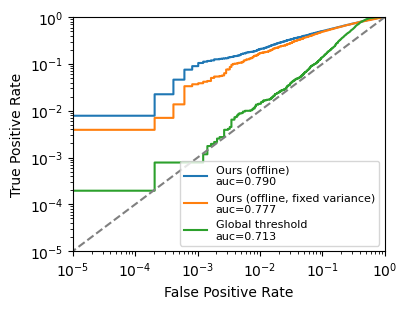

In [26]:
# def fig_fpr_tpr():

plt.figure(figsize=(4, 3))

# do_plot(generate_ours, keep, scores, v_keep, v_scores, 1, "Ours (online)\n", metric="auc")

# do_plot(functools.partial(generate_ours, fix_variance=True), keep, scores, v_keep, v_scores, 1, "Ours (online, fixed variance)\n", metric="auc")

do_plot(functools.partial(generate_ours_offline), keep, scores, v_keep, v_scores, 1, "Ours (offline)\n", metric="auc")

do_plot(functools.partial(generate_ours_offline, fix_variance=True), keep, scores, v_keep, v_scores, 1, "Ours (offline, fixed variance)\n", metric="auc")

do_plot(generate_global, keep, scores, v_keep, v_scores, 1, "Global threshold\n", metric="auc")

plt.semilogx()
plt.semilogy()
plt.xlim(1e-5, 1)
plt.ylim(1e-5, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], ls="--", color="gray")
plt.subplots_adjust(bottom=0.18, left=0.18, top=0.96, right=0.96)
plt.legend(fontsize=8)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
filename = f"fprtpr_{model}_{current_time}.png"

plt.savefig("figures/" + filename)
plt.show()